# Import libraries

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load data

In [2]:
data_dir = Path("../../data/1000G")
chunks_root = os.path.join(data_dir, "chunks")
non_snp_cols = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE']
# We'll add the parsed population info, too:
derived_cols = ['population', 'subpopulation']
non_snp_cols_full = non_snp_cols + derived_cols
pc_range = [1, 2, 3, 4, 5, 10, 30, 50, 100]
#pc_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20]
max_nr_pcs = 1000
pcs_df = pd.read_pickle(f"{data_dir}/pca/1000G_{max_nr_pcs}_PCs.pkl")


# Fast version

In [3]:
"""
FAST VERSION
"""
def impute_inplace(A, fill_for_all_nan=0.0):
    # A is (N,M) float with NaNs
    col_means = np.nanmean(A, axis=0)
    col_means = np.where(np.isnan(col_means), fill_for_all_nan, col_means)
    r, c = np.where(np.isnan(A))
    if r.size:
        A[r, c] = col_means[c]

compare_pcs = pd.DataFrame()
for PC_nr in pc_range:
    print(PC_nr)
    PCS_cols = [f"PC{a+1}" for a in range(PC_nr)]
    pcs_temp = pcs_df[PCS_cols]

    # --- Build X as a NumPy array (N,p) with intercept ---
    X_pc = pcs_temp.to_numpy(dtype=np.float64)              # (N, PC_nr)
    X = np.concatenate([np.ones((X_pc.shape[0], 1)), X_pc], axis=1)  # (N, p=PC_nr+1)

    # Precompute P = (X'X)^(-1) X' using solve (avoids explicit inverse)
    XtX = X.T @ X                                           # (p,p)
    P = np.linalg.solve(XtX, X.T)                           # (p,N)

    F_chroms = []

    for chrom in sorted(os.listdir(chunks_root)):
        print(f"chrom = {chrom}")
        chrom_path = f"{chunks_root}/{chrom}"
        if not os.path.isdir(chrom_path):
            continue

        chunk_files = sorted(f for f in os.listdir(chrom_path) if f.endswith(".pkl"))
        if not chunk_files:
            continue

        F_chunks = []

        for fname in chunk_files:
            path_chunk = f"{chrom_path}/{fname}"
            df = pd.read_pickle(path_chunk)

            snp_cols = [c for c in df.columns if c not in non_snp_cols_full]
            if not snp_cols:
                continue

            # Genotype/het as NumPy
            G = df[snp_cols].to_numpy(dtype=np.float64)                  # (N,M)
            H = (df[snp_cols].to_numpy(dtype=np.float64) == 0.0).astype(np.float64)

            # --- Sanity check: row counts must match between PCs and genotypes
            if X.shape[0] != G.shape[0]:
                raise ValueError(f"Row mismatch: PCs N={X.shape[0]} vs genotypes N={G.shape[0]}")

            # Impute NaNs per column
            impute_inplace(G, fill_for_all_nan=0.0)
            impute_inplace(H, fill_for_all_nan=0.0)

            # Batched OLS predictions (all NumPy → no label alignment)
            BG = P @ G                  # (p,M)
            EG = X @ BG                 # (N,M)

            BH = P @ H                  # (p,M)
            EH = X @ BH                 # (N,M)

            # F-hat
            p_hat = np.clip((EG + 1.0) / 2.0, 1e-6, 1 - 1e-6)
            denom = np.clip(2.0 * p_hat * (1.0 - p_hat), 1e-6, None)
            F_hat = np.clip(1.0 - (EH / denom), 0.0, 1.0)                # (N,M)

            #eps_abs = 1e-12          # absolute floor to avoid divide-by-zero
            
            #p_hat = (EG + 1.0) / 2.0
            #denom = 2.0 * p_hat * (1.0 - p_hat)
            #denom_stable = denom + eps_abs
            #F_hat = 1.0 - (EH / denom_stable)
            F_chunks.append(F_hat.mean(axis=1))                           # (N,)

        if F_chunks:
            F_mean_per_ind_chr = np.mean(np.column_stack(F_chunks), axis=1)
            F_chroms.append(F_mean_per_ind_chr)

    if F_chroms:
        F_mean_per_ind_per_chrom = np.mean(np.column_stack(F_chroms), axis=1)
    compare_pcs[f"{PC_nr}PCs"] = F_mean_per_ind_per_chrom

1
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
2
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
3
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
4
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
5
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
10
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
30
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
50
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
100
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22


In [4]:
df = compare_pcs.copy()

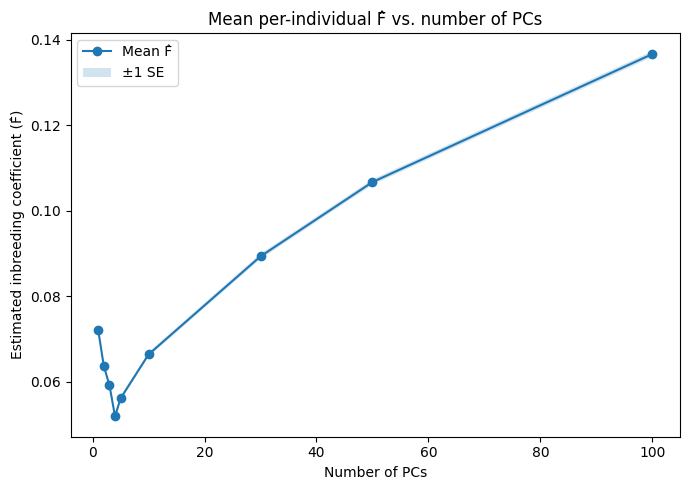

In [5]:
import matplotlib.pyplot as plt

mean_vals = df.mean(axis=0)   # mean per PC
std_vals  = df.std(axis=0)
se_vals   = std_vals / (df.shape[0] ** 0.5)

x = [int(col.replace("PCs","")) for col in df.columns]

plt.figure(figsize=(7,5))
plt.plot(x, mean_vals, marker="o", label="Mean F̂")
plt.fill_between(x, mean_vals - se_vals, mean_vals + se_vals, alpha=0.2, label="±1 SE")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient (F̂)")
plt.title("Mean per-individual F̂ vs. number of PCs")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_4002/343561853.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")


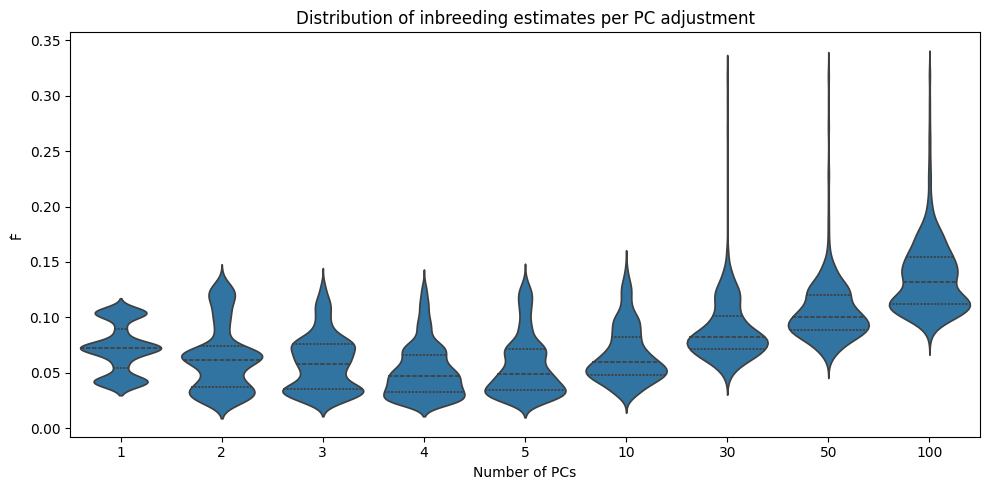

In [6]:
import seaborn as sns

df_long = df.melt(var_name="PCs", value_name="F")
df_long["PCs"] = df_long["PCs"].str.replace("PCs","").astype(int)

plt.figure(figsize=(10,5))
sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Distribution of inbreeding estimates per PC adjustment")
plt.tight_layout()
plt.show()


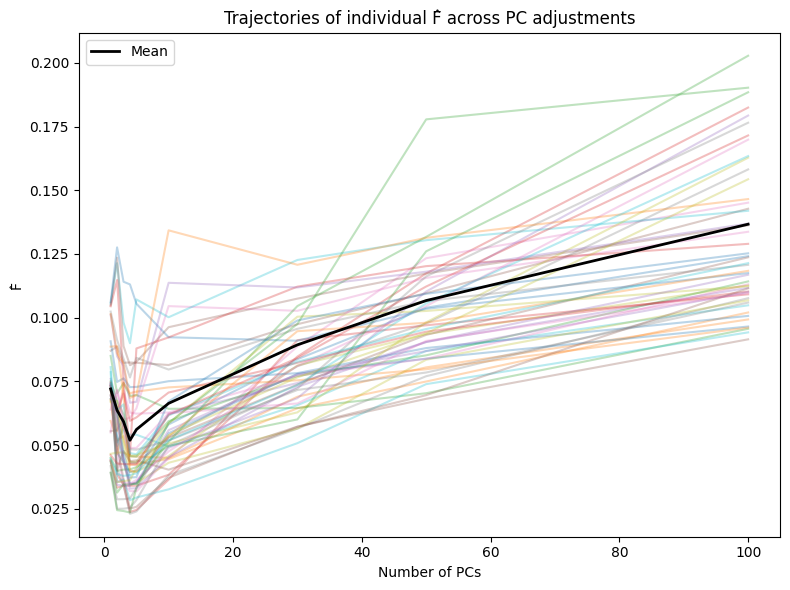

In [7]:
subset = df.sample(n=50, random_state=1)   # random subset of individuals
x = [int(c.replace("PCs","")) for c in df.columns]

plt.figure(figsize=(8,6))
for i, row in subset.iterrows():
    plt.plot(x, row.values, alpha=0.3)

plt.plot(x, df.mean(axis=0), color="black", linewidth=2, label="Mean")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Trajectories of individual F̂ across PC adjustments")
plt.legend()
plt.tight_layout()
plt.show()


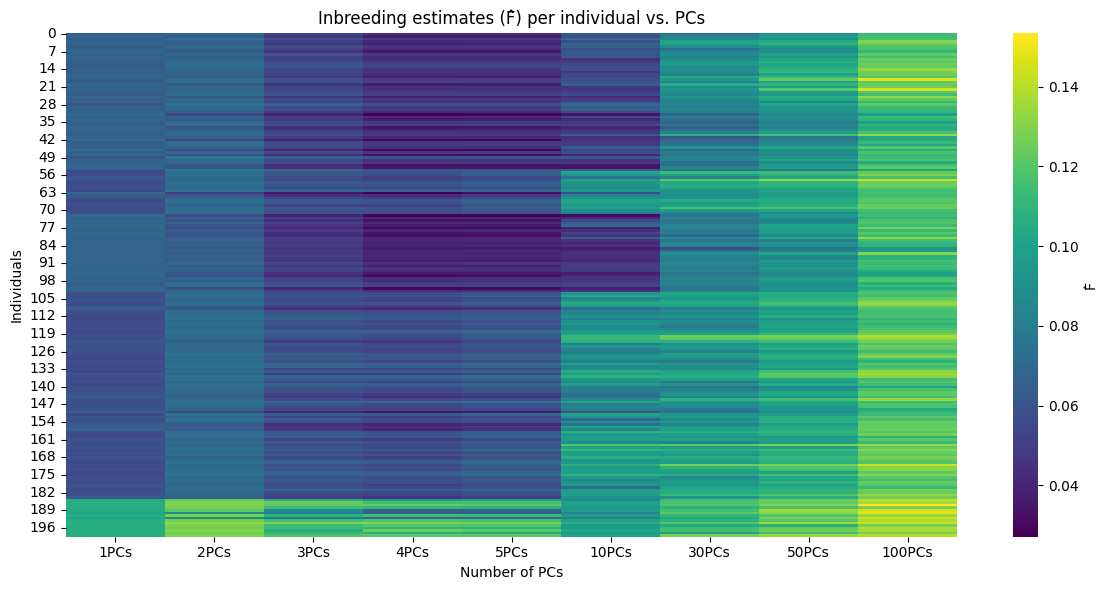

In [8]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df.iloc[:200], cmap="viridis", cbar_kws={'label': 'F̂'})  # first 200 individuals
plt.xlabel("Number of PCs")
plt.ylabel("Individuals")
plt.title("Inbreeding estimates (F̂) per individual vs. PCs")
plt.tight_layout()
plt.show()


# Long version

In [ ]:
"""
Longer version
"""
# ----------------------------
# Config / paths / constants
# ----------------------------
path_1K = "../../data/1000G/"
chunks_root = os.path.join(path_1K, "chunks")

non_snp_cols = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE']
derived_cols = ['population', 'subpopulation']
non_snp_cols_full = non_snp_cols + derived_cols

pheno_saved = False

# -------------------------------------------------------------------
# Ensure PCs are indexed by IID strings once
# Expect pcs_df to have IID either as index or a column named "IID"
# -------------------------------------------------------------------
if 'FID' in pcs_df.columns:
    pcs_df = pcs_df.set_index(pcs_df['FID'].astype(str))
else:
    pcs_df.index = pcs_df.index.astype(str)

# Keep your original slice; adjust if you intended more
compare_pcs = pd.DataFrame()
for PC_nr in pc_range:
    print(PC_nr)
    # -------------------------------
    # Build PC column list defensively
    # -------------------------------
    PCS_cols = [f"PC{a+1}" for a in range(PC_nr)]
    PCS_cols = [c for c in PCS_cols if c in pcs_df.columns]
    if len(PCS_cols) == 0:
        raise ValueError("No PC columns found in pcs_df matching the requested range.")

    # ---------------------------------------
    # Design matrix with intercept; IID index
    # ---------------------------------------
    X = sm.add_constant(pcs_df[PCS_cols], has_constant='add').astype('float64')

    # ----------------------------------------------------
    # Iterate chromosomes → chunks; compute F per individual
    # ----------------------------------------------------
    F_chroms = []

    for chrom in sorted(os.listdir(chunks_root)):
        print(chrom)
        path_chrom = os.path.join(chunks_root, chrom)
        if not os.path.isdir(path_chrom):
            continue

        chunks = sorted(os.listdir(path_chrom))
        if not chunks:
            continue

        # ------------------------------------------------------------
        # Build and save pheno once from the very first chunk encountered
        # ------------------------------------------------------------
        if not pheno_saved:
            first_path = os.path.join(path_chrom, chunks[0])
            first = pd.read_pickle(first_path)

            split_cols = first['IID'].astype(str).str.split('_', n=1, expand=True)
            first['subpopulation'] = split_cols[0]
            first['population'] = split_cols[1] if split_cols.shape[1] > 1 else pd.NA

            keep_cols = [c for c in non_snp_cols_full if c in first.columns]
            pheno = first[keep_cols].drop_duplicates().reset_index(drop=True)
            # e.g. pheno.to_pickle(os.path.join(out_root, "pheno.pkl"))
            pheno_saved = True

        F_chunks = []

        # ----------------------
        # Process each chunk file
        # ----------------------
        for chunk in chunks:
            path_chunk = os.path.join(path_chrom, chunk)

            try:
                df = pd.read_pickle(path_chunk)
            except Exception as e:
                print(f"Skipping {path_chunk} (read error: {e})")
                continue

            # Require FID
            if 'FID' not in df.columns:
                print(f"Skipping {path_chunk} (no FID column)")
                continue

            fids = df['FID'].astype(str)

            # Drop non-SNP columns and coerce SNPs to float (avoid nullable Int dtypes)
            drop_cols = [c for c in non_snp_cols_full if c in df.columns]
            geno = df.drop(columns=drop_cols, errors='ignore')
            geno = geno.apply(pd.to_numeric, errors='coerce').astype('float64')

            if geno.shape[1] == 0:
                continue

            # Set FID index for genotypes
            geno.index = fids

            # Heterozygote indicator for {-1,0,1} coding: het == 1 when genotype == 0
            het = (geno == 0).astype('int8')

            # Align PCs to this chunk's individuals
            X_chunk = X.reindex(fids)
            valid_X = X_chunk.notna().all(axis=1)

            # list of Series (per-SNP F̂) with IID index
            F_chunk_series = []

            # -------------
            # Iterate SNPs
            # -------------
            for snp in geno.columns:
                yG = geno[snp]

                # mask: valid PCs and non-missing genotype
                mask = valid_X & yG.notna()
                if mask.sum() < 5:
                    # too few samples for a stable fit
                    continue

                Xs = X_chunk.loc[mask].astype('float64')
                g = yG.loc[mask].astype('float64')

                # Convert to NumPy float arrays for statsmodels
                Xmat = Xs.to_numpy(dtype='float64')
                y = g.to_numpy(dtype='float64')

                # OLS for E[G | PCs], G in {-1,0,1}
                modG = sm.OLS(y, Xmat).fit()
                EG = pd.Series(modG.predict(Xmat), index=Xs.index)

                # p_hat from E[G] via 2p - 1 => p = (EG + 1)/2
                p_hat = ((EG + 1.0) / 2.0).clip(1e-6, 1 - 1e-6)

                # Heterozygote model (binary): H = 1{G==0}
                h = het[snp].loc[mask].astype('float64')
                yH = h.to_numpy(dtype='float64')

                modH = sm.OLS(yH, Xmat).fit()
                EH = pd.Series(modH.predict(Xmat), index=Xs.index).clip(1e-6, 1 - 1e-6)

                # Protect against tiny denominators
                denom = (2.0 * p_hat * (1.0 - p_hat)).clip(lower=1e-6)

                F_hat = (1.0 - (EH / denom)).clip(0.0, 1.0)
                F_chunk_series.append(F_hat)

            # Mean across SNPs within the chunk, aligned by IID
            if F_chunk_series:
                F_mean_per_ind = pd.concat(F_chunk_series, axis=1).mean(axis=1)
                F_chunks.append(F_mean_per_ind)

        # Mean across chunks for this chromosome
        if F_chunks:
            F_mean_per_ind_chr = pd.concat(F_chunks, axis=1).mean(axis=1)
            F_chroms.append(F_mean_per_ind_chr)

    # --- Final aggregate: mean across chromosomes ---
    if F_chroms:
        F_mean_per_ind_per_chrom = pd.concat(F_chroms, axis=1).mean(axis=1)
    else:
        F_mean_per_ind_per_chrom = pd.Series(dtype=float)
    compare_pcs[f"{PC_nr}PCs"] = F_mean_per_ind_per_chrom

1
chrom_20


In [10]:
df = compare_pcs.copy()

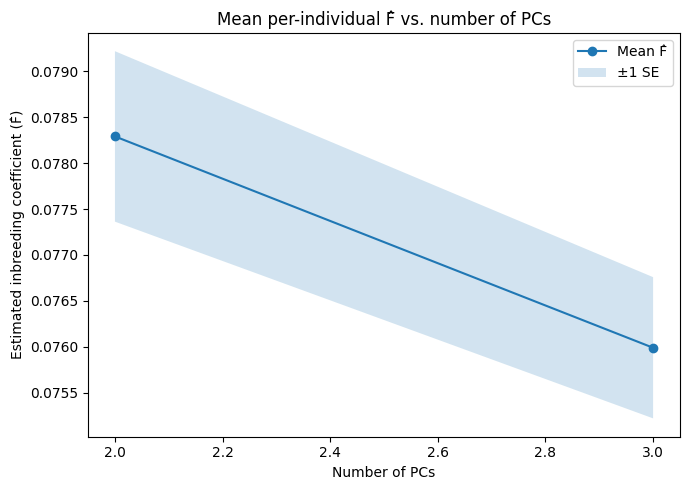

In [11]:
mean_vals = df.mean(axis=0)   # mean per PC
std_vals  = df.std(axis=0)
se_vals   = std_vals / (df.shape[0] ** 0.5)

x = [int(col.replace("PCs","")) for col in df.columns]

plt.figure(figsize=(7,5))
plt.plot(x, mean_vals, marker="o", label="Mean F̂")
plt.fill_between(x, mean_vals - se_vals, mean_vals + se_vals, alpha=0.2, label="±1 SE")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient (F̂)")
plt.title("Mean per-individual F̂ vs. number of PCs")
plt.legend()
plt.tight_layout()
plt.show()
